<a href="https://colab.research.google.com/github/anshkumar/elf/blob/master/NSMOCS_ANN_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "./drive/My Drive/data.zip" .

In [3]:
!unzip ./data.zip

Archive:  ./data.zip
   creating: data/
   creating: data/VIC/
  inflating: data/VIC/PRICE_AND_DEMAND_201501_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201711_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201710_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201612_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201706_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201707_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201604_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201605_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201510_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201511_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201701_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201609_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201608_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201603_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201602_VIC1.csv  
  inflating: data/VIC/PRICE_AND_DEMAND_201507_VIC1.csv  
  inflating: data/VIC/PRI

In [0]:
class sw(object):

    def __init__(self):

        self.__Positions = []
        self.__Gbest = []

    def _set_Gbest(self, Gbest):
        self.__Gbest = Gbest

    def _points(self, agents):
        self.__Positions.append([list(i) for i in agents])

    def get_agents(self):
        """Returns a history of all agents of the algorithm (return type:
        list)"""

        return self.__Positions

    def get_Gbest(self):
        """Return the best position of algorithm (return type: list)"""

        return list(self.__Gbest)


In [0]:
# -*- coding: utf-8 -*-

"""
@author: vedanshu
"""

import numpy as np
from math import gamma, pi, sin, sqrt
from random import normalvariate, randint, random

class Activation(object):
    @staticmethod
    def sigmoid(z):
        return 1.0/(1.0 + np.exp(-z))
    
    @staticmethod
    def sigmoid_prime(z):
        return Activation.sigmoid(z)*(1 - Activation.sigmoid(z))

    @staticmethod        
    def tanh(z):
        return 2*Activation.sigmoid(2*z) - 1
        
    @staticmethod
    def relu(z):
        return z * (z > 0)

class Swarm(sw):
    def __init__(self, sizes, activate):
        self.sizes = sizes
        self.activate = activate
        self.dim = sum(x*(y+1) for x,y in zip(self.sizes[1:], self.sizes[:-1]))
        
    def feedforward(self,a):
        for b,w in zip(self.biases, self.weights):
            a  = (self.activate)(np.matmul(w,a) + b)
        return a
    
    def set_weight_bias(self, a):
        lIt = 0
        rIt = 0
        self.weights = []
        self.biases = []
        for x,y in zip(self.sizes[1:], self.sizes[:-1]):
            rIt += x*y
            self.weights.append(a[lIt:rIt].reshape((x,y)))
            lIt = rIt
        for x in self.sizes[1:]:
            rIt += x
            self.biases.append(a[lIt:rIt].reshape((x,1)))
            lIt = rIt
    
    """
    Cuckoo Search Optimization
    """
    
    def multiObjectiveFunction(self,x):
        self.set_weight_bias(x)
        y_prime = self.feedforward(self.input)
        ob1 = sum(abs(u-v) for u,v in zip(y_prime, self.output))/x.shape[0]
        ob2 = sqrt(sum((u-v)**2 for u,v in zip(y_prime, self.output))/x.shape[0])
        ob3 = sum(abs((u-v)/v) for u,v in zip(y_prime, self.output))/x.shape[0]
        ob4 = sqrt(sum((abs((u-v)/v) - ob3)**2 for u,v in zip(y_prime, self.output))/x.shape[0])
        return min([ob1,ob2,ob3,ob4])

    def cso(self, n, x, y, function, lb, ub, dimension, iteration, pa=0.25,
                 nest=100):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: number of iterations
        :param pa: probability of cuckoo's egg detection (default value is 0.25)
        :param nest: number of nests (default value is 100)
        """

        super(Swarm, self).__init__()

        self.__Nests = []
        
        self.input = x
        self.output = y

        beta = 3 / 2
        sigma = (gamma(1 + beta) * sin(pi * beta / 2) / (
            gamma((1 + beta) / 2) * beta *
            2 ** ((beta - 1) / 2))) ** (1 / beta)
        u = np.array([normalvariate(0, 1) for k in range(dimension)]) * sigma
        v = np.array([normalvariate(0, 1) for k in range(dimension)])
        step = u / abs(v) ** (1 / beta)

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        self.__nests = np.random.uniform(lb, ub, (nest, dimension))
        Pbest = self.__nests[np.array([function(x)
                                       for x in self.__nests]).argmin()]
        Gbest = Pbest
        self._points(self.__agents)

        for t in range(iteration):

            for i in self.__agents:
                val = randint(0, nest - 1)
                if function(i) < function(self.__nests[val]):
                    self.__nests[val] = i

            fnests = [(function(self.__nests[i]), i) for i in range(nest)]
            fnests.sort()
            fcuckoos = [(function(self.__agents[i]), i) for i in range(n)]
            fcuckoos.sort(reverse=True)

            nworst = nest // 2
            worst_nests = [fnests[-i - 1][1] for i in range(nworst)]

            for i in worst_nests:
                if random() < pa:
                    self.__nests[i] = np.random.uniform(lb, ub, (1, dimension))

            if nest > n:
                mworst = n
            else:
                mworst = nest

            for i in range(mworst):

                if fnests[i][0] < fcuckoos[i][0]:
                    self.__agents[fcuckoos[i][1]] = self.__nests[fnests[i][1]]

            self.__nests = np.clip(self.__nests, lb, ub)
            self.__Levyfly(step, Pbest, n, dimension)
            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)
            self.__nest()

            Pbest = self.__nests[np.array([function(x)
                                        for x in self.__nests]).argmin()]

            if function(Pbest) < function(Gbest):
                Gbest = Pbest

        self._set_Gbest(Gbest)

    def __nest(self):
        self.__Nests.append([list(i) for i in self.__nests])

    def __Levyfly(self, step, Pbest, n, dimension):

        for i in range(n):
            stepsize = 0.2 * step * (self.__agents[i] - Pbest)
            self.__agents[i] += stepsize * np.array([normalvariate(0, 1)
                                                    for k in range(dimension)])

    def get_nests(self):
        """Return a history of cuckoos nests (return type: list)"""

        return self.__Nests
    


In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import json
from matplotlib import rc

#State and year to use for training and testing
state = {0: 'NSW', 1: 'QLD', 2: 'SA', 3: 'TAS', 4: 'VIC'}
#state = {0: 'NSW'}
year = {0: '2015', 1: '2016'}
#year = {0: '2015'}
year_test = {0: '2017'}

#forecasting parameters
num_periods = 12
f_horizon = 24  #forecast horizon

hidden = 10

#Training and testing batches
x_batches = {}
y_batches = {} 
x_batches_test = {}
y_batches_test = {}

#parameters for 5 fold validation 
set_size = 84 
x_size = 36
y_size = 48
x_batches_validation_fold ={}
y_batches_validation_fold ={}
x_batches_train_fold = {}
y_batches_train_fold = {}

In [0]:
def loadData5Folds():
    global x_batches
    global y_batches
    global x_batches_test
    global y_batches_test
    global x_batches_validation_fold
    global y_batches_validation_fold
    global x_batches_train_fold
    global y_batches_train_fold
    
    df_nsw = pd.DataFrame()
    df_qld = pd.DataFrame()
    df_sa = pd.DataFrame()
    df_tas = pd.DataFrame()
    df_vic = pd.DataFrame()
    
    
    df = {'NSW': df_nsw, 'QLD': df_qld, 'SA': df_sa, 'TAS': df_tas, 'VIC': df_vic}
    
    for st in state.values():
        for ye in year.values():
            for mn in range(1,13):
                if mn < 10:            
                    dataset = pd.read_csv('./data/' + st + '/PRICE_AND_DEMAND_' + ye + '0' + str(mn) +'_' + st + '1.csv')
                else:
                    dataset = pd.read_csv('./data/' + st + '/PRICE_AND_DEMAND_' + ye + str(mn) +'_' + st + '1.csv')
                df[st] = df[st].append(dataset.iloc[:,1:3])
        df[st] = df[st].set_index('SETTLEMENTDATE')
    
    TS_NSW = np.array(df['NSW'])
    TS_QLD = np.array(df['QLD'])
    TS_SA = np.array(df['SA'])
    TS_TAS = np.array(df['TAS'])
    TS_VIC = np.array(df['VIC'])
      
    #Normalizing the dataset
    TS_NSW = TS_NSW / np.linalg.norm(TS_NSW)
    TS_QLD = TS_QLD / np.linalg.norm(TS_QLD)
    TS_SA = TS_SA / np.linalg.norm(TS_SA)
    TS_TAS = TS_TAS / np.linalg.norm(TS_TAS)
    TS_VIC = TS_VIC / np.linalg.norm(TS_VIC)

    """ Making the dataset size divisible by num_period """
    TS_NSW = TS_NSW[:(len(TS_NSW) -(len(TS_NSW) % set_size))] 
    TS_QLD = TS_QLD[:(len(TS_QLD)- (len(TS_QLD) % set_size))]
    TS_SA = TS_SA[:(len(TS_SA) -(len(TS_SA) % set_size))]
    TS_TAS = TS_TAS[:(len(TS_TAS) -(len(TS_TAS) % set_size))]
    TS_VIC = TS_VIC[:(len(TS_VIC) - (len(TS_VIC) % set_size))] 
    
    """ Making our training dataset with batch size of num_period """
    TS_batches = {'NSW': TS_NSW.reshape(-1, set_size).transpose(),
                 'QLD': TS_QLD.reshape(-1, set_size).transpose(),
                 'SA': TS_SA.reshape(-1, set_size).transpose(),
                 'TAS': TS_TAS.reshape(-1, set_size).transpose(),
                 'VIC': TS_VIC.reshape(-1, set_size).transpose()}
    
    x_batches = {'NSW': TS_batches['NSW'][:x_size,:(TS_batches['NSW'].shape[1]-TS_batches['NSW'].shape[1]%5)],
                 'QLD': TS_batches['QLD'][:x_size,:(TS_batches['QLD'].shape[1]-TS_batches['QLD'].shape[1]%5)],
                 'SA': TS_batches['SA'][:x_size,:(TS_batches['SA'].shape[1]-TS_batches['SA'].shape[1]%5)],
                 'TAS': TS_batches['TAS'][:x_size,:(TS_batches['TAS'].shape[1]-TS_batches['TAS'].shape[1]%5)],
                 'VIC': TS_batches['VIC'][:x_size,:(TS_batches['VIC'].shape[1]-TS_batches['VIC'].shape[1]%5)]}
    
    y_batches = {'NSW': TS_batches['NSW'][x_size:,:(TS_batches['NSW'].shape[1]-TS_batches['NSW'].shape[1]%5)],
                 'QLD': TS_batches['QLD'][x_size:,:(TS_batches['QLD'].shape[1]-TS_batches['QLD'].shape[1]%5)],
                 'SA': TS_batches['SA'][x_size:,:(TS_batches['SA'].shape[1]-TS_batches['SA'].shape[1]%5)],
                 'TAS': TS_batches['TAS'][x_size:,:(TS_batches['TAS'].shape[1]-TS_batches['TAS'].shape[1]%5)],
                 'VIC': TS_batches['VIC'][x_size:,:(TS_batches['VIC'].shape[1]-TS_batches['VIC'].shape[1]%5)]}


    #Making validation set
    x_batches_validation_fold[1] = {'NSW': x_batches['NSW'][:, np.arange(0,x_batches['NSW'].shape[1],5)],
                             'QLD': x_batches['QLD'][:, np.arange(0,x_batches['QLD'].shape[1],5)],
                             'SA': x_batches['SA'][:, np.arange(0,x_batches['SA'].shape[1],5)],
                             'TAS': x_batches['TAS'][:, np.arange(0,x_batches['TAS'].shape[1],5)],
                             'VIC': x_batches['VIC'][:, np.arange(0,x_batches['VIC'].shape[1],5)]}
    
    x_batches_validation_fold[2] = {'NSW': x_batches['NSW'][:, np.arange(1,x_batches['NSW'].shape[1],5)],
                             'QLD': x_batches['QLD'][:, np.arange(1,x_batches['QLD'].shape[1],5)],
                             'SA': x_batches['SA'][:, np.arange(1,x_batches['SA'].shape[1],5)],
                             'TAS': x_batches['TAS'][:, np.arange(1,x_batches['TAS'].shape[1],5)],
                             'VIC': x_batches['VIC'][:, np.arange(1,x_batches['VIC'].shape[1],5)]}
    
    x_batches_validation_fold[3] = {'NSW': x_batches['NSW'][:, np.arange(2,x_batches['NSW'].shape[1],5)],
                             'QLD': x_batches['QLD'][:, np.arange(2,x_batches['QLD'].shape[1],5)],
                             'SA': x_batches['SA'][:, np.arange(2,x_batches['SA'].shape[1],5)],
                             'TAS': x_batches['TAS'][:, np.arange(2,x_batches['TAS'].shape[1],5)],
                             'VIC': x_batches['VIC'][:, np.arange(2,x_batches['VIC'].shape[1],5)]}
    
    x_batches_validation_fold[4] = {'NSW': x_batches['NSW'][:,np.arange(3,x_batches['NSW'].shape[1],5)],
                             'QLD': x_batches['QLD'][:, np.arange(3,x_batches['QLD'].shape[1],5)],
                             'SA': x_batches['SA'][:, np.arange(3,x_batches['SA'].shape[1],5)],
                             'TAS': x_batches['TAS'][:, np.arange(3,x_batches['TAS'].shape[1],5)],
                             'VIC': x_batches['VIC'][:, np.arange(3,x_batches['VIC'].shape[1],5)]}
    
    x_batches_validation_fold[5] = {'NSW': x_batches['NSW'][:, np.arange(4,x_batches['NSW'].shape[1],5)],
                             'QLD': x_batches['QLD'][:, np.arange(4,x_batches['QLD'].shape[1],5)],
                             'SA': x_batches['SA'][:, np.arange(4,x_batches['SA'].shape[1],5)],
                             'TAS': x_batches['TAS'][:, np.arange(4,x_batches['TAS'].shape[1],5)],
                             'VIC': x_batches['VIC'][:, np.arange(4,x_batches['VIC'].shape[1],5)]}
     
    y_batches_validation_fold[1] = {'NSW': y_batches['NSW'][:, np.arange(0,y_batches['NSW'].shape[1],5)],
                             'QLD': y_batches['QLD'][:, np.arange(0,y_batches['QLD'].shape[1],5)],
                             'SA': y_batches['SA'][:, np.arange(0,y_batches['SA'].shape[1],5)],
                             'TAS': y_batches['TAS'][:, np.arange(0,y_batches['TAS'].shape[1],5)],
                             'VIC': y_batches['VIC'][:, np.arange(0,y_batches['VIC'].shape[1],5)]}
    
    y_batches_validation_fold[2] = {'NSW': y_batches['NSW'][:, np.arange(1,y_batches['NSW'].shape[1],5)],
                             'QLD': y_batches['QLD'][:, np.arange(1,y_batches['QLD'].shape[1],5)],
                             'SA': y_batches['SA'][:, np.arange(1,y_batches['SA'].shape[1],5)],
                             'TAS': y_batches['TAS'][:, np.arange(1,y_batches['TAS'].shape[1],5)],
                             'VIC': y_batches['VIC'][:, np.arange(1,y_batches['VIC'].shape[1],5)]}
    
    y_batches_validation_fold[3] = {'NSW': y_batches['NSW'][:, np.arange(2,y_batches['NSW'].shape[1],5)],
                             'QLD': y_batches['QLD'][:, np.arange(2,y_batches['QLD'].shape[1],5)],
                             'SA': y_batches['SA'][:, np.arange(2,y_batches['SA'].shape[1],5)],
                             'TAS': y_batches['TAS'][:, np.arange(2,y_batches['TAS'].shape[1],5)],
                             'VIC': y_batches['VIC'][:, np.arange(2,y_batches['VIC'].shape[1],5)]}
    
    y_batches_validation_fold[4] = {'NSW': y_batches['NSW'][:, np.arange(3,y_batches['NSW'].shape[1],5)],
                             'QLD': y_batches['QLD'][:, np.arange(3,y_batches['QLD'].shape[1],5)],
                             'SA': y_batches['SA'][:, np.arange(3,y_batches['SA'].shape[1],5)],
                             'TAS': y_batches['TAS'][:, np.arange(3,y_batches['TAS'].shape[1],5)],
                             'VIC': y_batches['VIC'][:, np.arange(3,y_batches['VIC'].shape[1],5)]}
    
    y_batches_validation_fold[5] = {'NSW': y_batches['NSW'][:, np.arange(4,y_batches['NSW'].shape[1],5)],
                             'QLD': y_batches['QLD'][:, np.arange(4,y_batches['QLD'].shape[1],5)],
                             'SA': y_batches['SA'][:, np.arange(4,y_batches['SA'].shape[1],5)],
                             'TAS': y_batches['TAS'][:, np.arange(4,y_batches['TAS'].shape[1],5)],
                             'VIC': y_batches['VIC'][:, np.arange(4,y_batches['VIC'].shape[1],5)]}
 
    
    #Making training sets
    x_batches_train_fold[1] = {'NSW': x_batches['NSW'][:, [x for x in np.arange(0,x_batches['NSW'].shape[1]) if x not in np.arange(0,x_batches['NSW'].shape[1],5)] ],
                             'QLD': x_batches['QLD'][:, [x for x in np.arange(0,x_batches['QLD'].shape[1]) if x not in np.arange(0,x_batches['QLD'].shape[1],5)] ],
                             'SA': x_batches['SA'][:, [x for x in np.arange(0,x_batches['SA'].shape[1]) if x not in np.arange(0,x_batches['SA'].shape[1],5)] ],
                             'TAS': x_batches['TAS'][:, [x for x in np.arange(0,x_batches['TAS'].shape[1]) if x not in np.arange(0,x_batches['TAS'].shape[1],5)] ],
                             'VIC': x_batches['VIC'][:, [x for x in np.arange(0,x_batches['VIC'].shape[1]) if x not in np.arange(0,x_batches['VIC'].shape[1],5)] ]}
    
    x_batches_train_fold[2] = {'NSW': x_batches['NSW'][:, [x for x in np.arange(1,x_batches['NSW'].shape[1]) if x not in np.arange(1,x_batches['NSW'].shape[1],5)] ],
                             'QLD': x_batches['QLD'][:, [x for x in np.arange(1,x_batches['QLD'].shape[1]) if x not in np.arange(1,x_batches['QLD'].shape[1],5)] ],
                             'SA': x_batches['SA'][:, [x for x in np.arange(1,x_batches['SA'].shape[1]) if x not in np.arange(1,x_batches['SA'].shape[1],5)] ],
                             'TAS': x_batches['TAS'][:, [x for x in np.arange(1,x_batches['TAS'].shape[1]) if x not in np.arange(1,x_batches['TAS'].shape[1],5)] ],
                             'VIC': x_batches['VIC'][:, [x for x in np.arange(1,x_batches['VIC'].shape[1]) if x not in np.arange(1,x_batches['VIC'].shape[1],5)] ]}
    
    x_batches_train_fold[3] = {'NSW': x_batches['NSW'][:, [x for x in np.arange(2,x_batches['NSW'].shape[1]) if x not in np.arange(2,x_batches['NSW'].shape[1],5)] ],
                             'QLD': x_batches['QLD'][:, [x for x in np.arange(2,x_batches['QLD'].shape[1]) if x not in np.arange(2,x_batches['QLD'].shape[1],5)] ],
                             'SA': x_batches['SA'][:, [x for x in np.arange(2,x_batches['SA'].shape[1]) if x not in np.arange(2,x_batches['SA'].shape[1],5)] ],
                             'TAS': x_batches['TAS'][:, [x for x in np.arange(2,x_batches['TAS'].shape[1]) if x not in np.arange(2,x_batches['TAS'].shape[1],5)] ],
                             'VIC': x_batches['VIC'][:, [x for x in np.arange(2,x_batches['VIC'].shape[1]) if x not in np.arange(2,x_batches['VIC'].shape[1],5)] ]}
    
    x_batches_train_fold[4] = {'NSW': x_batches['NSW'][:, [x for x in np.arange(3,x_batches['NSW'].shape[1]) if x not in np.arange(3,x_batches['NSW'].shape[1],5)] ],
                             'QLD': x_batches['QLD'][:, [x for x in np.arange(3,x_batches['QLD'].shape[1]) if x not in np.arange(3,x_batches['QLD'].shape[1],5)] ],
                             'SA': x_batches['SA'][:, [x for x in np.arange(3,x_batches['SA'].shape[1]) if x not in np.arange(3,x_batches['SA'].shape[1],5)] ],
                             'TAS': x_batches['TAS'][:, [x for x in np.arange(3,x_batches['TAS'].shape[1]) if x not in np.arange(3,x_batches['TAS'].shape[1],5)]],
                             'VIC': x_batches['VIC'][:, [x for x in np.arange(3,x_batches['VIC'].shape[1]) if x not in np.arange(3,x_batches['VIC'].shape[1],5)]]}
    
    x_batches_train_fold[5] = {'NSW': x_batches['NSW'][:, [x for x in np.arange(4,x_batches['NSW'].shape[1]) if x not in np.arange(4,x_batches['NSW'].shape[1],5)] ],
                             'QLD': x_batches['QLD'][:, [x for x in np.arange(4,x_batches['QLD'].shape[1]) if x not in np.arange(4,x_batches['QLD'].shape[1],5)] ],
                             'SA': x_batches['SA'][:, [x for x in np.arange(4,x_batches['SA'].shape[1]) if x not in np.arange(4,x_batches['SA'].shape[1],5)] ],
                             'TAS': x_batches['TAS'][:, [x for x in np.arange(4,x_batches['TAS'].shape[1]) if x not in np.arange(4,x_batches['TAS'].shape[1],5)] ],
                             'VIC': x_batches['VIC'][:, [x for x in np.arange(4,x_batches['VIC'].shape[1]) if x not in np.arange(4,x_batches['VIC'].shape[1],5)] ]}

    y_batches_train_fold[1] = {'NSW': y_batches['NSW'][:, [x for x in np.arange(0,y_batches['NSW'].shape[1]) if x not in np.arange(0,y_batches['NSW'].shape[1],5)] ],
                             'QLD': y_batches['QLD'][:, [x for x in np.arange(0,y_batches['QLD'].shape[1]) if x not in np.arange(0,y_batches['QLD'].shape[1],5)] ],
                             'SA': y_batches['SA'][:, [x for x in np.arange(0,y_batches['SA'].shape[1]) if x not in np.arange(0,y_batches['SA'].shape[1],5)] ],
                             'TAS': y_batches['TAS'][:, [x for x in np.arange(0,y_batches['TAS'].shape[1]) if x not in np.arange(0,y_batches['TAS'].shape[1],5)] ],
                             'VIC': y_batches['VIC'][:, [x for x in np.arange(0,y_batches['VIC'].shape[1]) if x not in np.arange(0,y_batches['VIC'].shape[1],5)] ]}
    
    y_batches_train_fold[2] = {'NSW': y_batches['NSW'][:, [x for x in np.arange(1,y_batches['NSW'].shape[1]) if x not in np.arange(1,y_batches['NSW'].shape[1],5)] ],
                             'QLD': y_batches['QLD'][:, [x for x in np.arange(1,y_batches['QLD'].shape[1]) if x not in np.arange(1,y_batches['QLD'].shape[1],5)] ],
                             'SA': y_batches['SA'][:, [x for x in np.arange(1,y_batches['SA'].shape[1]) if x not in np.arange(1,y_batches['SA'].shape[1],5)] ],
                             'TAS': y_batches['TAS'][:, [x for x in np.arange(1,y_batches['TAS'].shape[1]) if x not in np.arange(1,y_batches['TAS'].shape[1],5)] ],
                             'VIC': y_batches['VIC'][:, [x for x in np.arange(1,y_batches['VIC'].shape[1]) if x not in np.arange(1,y_batches['VIC'].shape[1],5)] ]}
    
    y_batches_train_fold[3] = {'NSW': y_batches['NSW'][:, [x for x in np.arange(2,y_batches['NSW'].shape[1]) if x not in np.arange(2,y_batches['NSW'].shape[1],5)] ],
                             'QLD': y_batches['QLD'][:, [x for x in np.arange(2,y_batches['QLD'].shape[1]) if x not in np.arange(2,y_batches['QLD'].shape[1],5)] ],
                             'SA': y_batches['SA'][:, [x for x in np.arange(2,y_batches['SA'].shape[1]) if x not in np.arange(2,y_batches['SA'].shape[1],5)] ],
                             'TAS': y_batches['TAS'][:, [x for x in np.arange(2,y_batches['TAS'].shape[1]) if x not in np.arange(2,y_batches['TAS'].shape[1],5)] ],
                             'VIC': y_batches['VIC'][:, [x for x in np.arange(2,y_batches['VIC'].shape[1]) if x not in np.arange(2,y_batches['VIC'].shape[1],5)] ]}
    
    y_batches_train_fold[4] = {'NSW': y_batches['NSW'][:, [x for x in np.arange(3,y_batches['NSW'].shape[1]) if x not in np.arange(3,y_batches['NSW'].shape[1],5)] ],
                             'QLD': y_batches['QLD'][:, [x for x in np.arange(3,y_batches['QLD'].shape[1]) if x not in np.arange(3,y_batches['QLD'].shape[1],5)] ],
                             'SA': y_batches['SA'][:, [x for x in np.arange(3,y_batches['SA'].shape[1]) if x not in np.arange(3,y_batches['SA'].shape[1],5)] ],
                             'TAS': y_batches['TAS'][:, [x for x in np.arange(3,y_batches['TAS'].shape[1]) if x not in np.arange(3,y_batches['TAS'].shape[1],5)] ],
                             'VIC': y_batches['VIC'][:, [x for x in np.arange(3,y_batches['VIC'].shape[1]) if x not in np.arange(3,y_batches['VIC'].shape[1],5)] ]}

    y_batches_train_fold[5] = {'NSW': y_batches['NSW'][:, [x for x in np.arange(4,y_batches['NSW'].shape[1]) if x not in np.arange(4,y_batches['NSW'].shape[1],5)] ],
                             'QLD': y_batches['QLD'][:, [x for x in np.arange(4,y_batches['QLD'].shape[1]) if x not in np.arange(4,y_batches['QLD'].shape[1],5)] ],
                             'SA': y_batches['SA'][:, [x for x in np.arange(4,y_batches['SA'].shape[1]) if x not in np.arange(4,y_batches['SA'].shape[1],5)] ],
                             'TAS': y_batches['TAS'][:, [x for x in np.arange(4,y_batches['TAS'].shape[1]) if x not in np.arange(4,y_batches['TAS'].shape[1],5)] ],
                             'VIC': y_batches['VIC'][:, [x for x in np.arange(4,y_batches['VIC'].shape[1]) if x not in np.arange(4,y_batches['VIC'].shape[1],5)] ]}

def loadData():
    global x_batches
    global y_batches
    global x_batches_test
    global y_batches_test
    
    df_nsw = pd.DataFrame()
    df_qld = pd.DataFrame()
    df_sa = pd.DataFrame()
    df_tas = pd.DataFrame()
    df_vic = pd.DataFrame()
    
    df_nsw_test = pd.DataFrame()
    df_qld_test = pd.DataFrame()
    df_sa_test = pd.DataFrame()
    df_tas_test = pd.DataFrame()
    df_vic_test = pd.DataFrame()
    
    df = {'NSW': df_nsw, 'QLD': df_qld, 'SA': df_sa, 'TAS': df_tas, 'VIC': df_vic}
    df_test = {'NSW': df_nsw_test, 'QLD': df_qld_test, 'SA': df_sa_test, 'TAS': df_tas_test, 'VIC': df_vic_test}
    
    for st in state.values():
        for ye in year.values():
            for mn in range(1,13):
                if mn < 10:            
                    dataset = pd.read_csv('./datasets/train/' + st + '/PRICE_AND_DEMAND_' + ye + '0' + str(mn) +'_' + st + '1.csv')
                else:
                    dataset = pd.read_csv('./datasets/train/' + st + '/PRICE_AND_DEMAND_' + ye + str(mn) +'_' + st + '1.csv')
                df[st] = df[st].append(dataset.iloc[:,1:3])
        df[st] = df[st].set_index('SETTLEMENTDATE')
    
    for st in state.values():
        for ye in year_test.values():
            for mn in range(1,13):
                if mn < 10:            
                    dataset = pd.read_csv('./datasets/train/' + st + '/PRICE_AND_DEMAND_' + ye + '0' + str(mn) +'_' + st + '1.csv')
                else:
                    dataset = pd.read_csv('./datasets/train/' + st + '/PRICE_AND_DEMAND_' + ye + str(mn) +'_' + st + '1.csv')
                df_test[st] = df_test[st].append(dataset.iloc[:,1:3])
        df_test[st] = df_test[st].set_index('SETTLEMENTDATE')
    
    #for st in state.values():
    #    dataset = pd.read_csv('./datasets/test/' + st + '/PRICE_AND_DEMAND_201801_' + st + '1.csv')
    #    df_test[st] = df_test[st].append(dataset.iloc[:,1:3])
    #    df_test[st] = df_test[st].set_index('SETTLEMENTDATE')
    
    TS_NSW = np.array(df['NSW'])
    TS_QLD = np.array(df['QLD'])
    TS_SA = np.array(df['SA'])
    TS_TAS = np.array(df['TAS'])
    TS_VIC = np.array(df['VIC'])
    
    TS_NSW_test = np.array(df_test['NSW'])
    TS_QLD_test = np.array(df_test['QLD'])
    TS_SA_test = np.array(df_test['SA'])
    TS_TAS_test = np.array(df_test['TAS'])
    TS_VIC_test = np.array(df_test['VIC'])
    
    """ Making the dataset size divisible by num_period """
    x_data_nsw = TS_NSW[:(len(TS_NSW) - f_horizon -((len(TS_NSW)-f_horizon) % num_periods))] 
    x_data_qld = TS_QLD[:(len(TS_QLD)- f_horizon - ((len(TS_QLD)-f_horizon) % num_periods))]
    x_data_sa = TS_SA[:(len(TS_SA)- f_horizon -((len(TS_SA)-f_horizon) % num_periods))]
    x_data_tas = TS_TAS[:(len(TS_TAS)- f_horizon -((len(TS_TAS)-f_horizon) % num_periods))]
    x_data_vic = TS_VIC[:(len(TS_VIC)-f_horizon-((len(TS_VIC)-f_horizon) % num_periods))] 
    
    """ Making our training dataset with batch size of num_period """
    x_batches = {'NSW': x_data_nsw.reshape(-1, num_periods).transpose(),
                 'QLD': x_data_qld.reshape(-1, num_periods).transpose(),
                 'SA': x_data_sa.reshape(-1, num_periods).transpose(),
                 'TAS': x_data_tas.reshape(-1, num_periods).transpose(),
                 'VIC': x_data_vic.reshape(-1, num_periods).transpose()}
    
    y_data_nsw = TS_NSW[f_horizon:(len(TS_NSW)-f_horizon-((len(TS_NSW)-f_horizon) % num_periods)+f_horizon)]
    y_data_qld = TS_QLD[f_horizon:(len(TS_QLD)-f_horizon-((len(TS_QLD)-f_horizon) % num_periods)+f_horizon)]
    y_data_sa = TS_SA[f_horizon:(len(TS_SA)-f_horizon-((len(TS_SA)-f_horizon) % num_periods)+f_horizon)]
    y_data_tas = TS_TAS[f_horizon:(len(TS_TAS)-f_horizon-((len(TS_TAS)-f_horizon) % num_periods)+f_horizon)]
    y_data_vic = TS_VIC[f_horizon:(len(TS_VIC)-f_horizon-((len(TS_VIC)-f_horizon) % num_periods)+f_horizon)]
    
    y_batches = {'NSW': y_data_nsw.reshape(-1, num_periods).transpose(),
                     'QLD': y_data_qld.reshape(-1, num_periods).transpose(),
                     'SA': y_data_sa.reshape(-1, num_periods).transpose(),
                     'TAS': y_data_tas.reshape(-1, num_periods).transpose(),
                     'VIC': y_data_vic.reshape(-1, num_periods).transpose()}
    
    """ Making the dataset size divisible by num_period """
    x_data_nsw_test = TS_NSW_test[:(len(TS_NSW_test)-f_horizon-((len(TS_NSW_test)-f_horizon) % num_periods))] 
    x_data_qld_test = TS_QLD_test[:(len(TS_QLD_test)-f_horizon-((len(TS_QLD_test)-f_horizon) % num_periods))]
    x_data_sa_test = TS_SA_test[:(len(TS_SA_test)-f_horizon-((len(TS_SA_test)-f_horizon) % num_periods))]
    x_data_tas_test = TS_TAS_test[:(len(TS_TAS_test)-f_horizon-((len(TS_TAS_test)-f_horizon) % num_periods))]
    x_data_vic_test = TS_VIC_test[:(len(TS_VIC_test)-f_horizon-((len(TS_VIC_test)-f_horizon) % num_periods))] 
    """ Making our training dataset with batch size of num_period """
    x_batches_test = {'NSW': x_data_nsw_test.reshape(-1, num_periods).transpose(),
                 'QLD': x_data_qld_test.reshape(-1, num_periods).transpose(),
                 'SA': x_data_sa_test.reshape(-1, num_periods).transpose(),
                 'TAS': x_data_tas_test.reshape(-1, num_periods).transpose(),
                 'VIC': x_data_vic_test.reshape(-1, num_periods).transpose()}
    
    y_data_nsw_test = TS_NSW_test[f_horizon:(len(TS_NSW_test)-(len(TS_NSW_test) % num_periods)+f_horizon)]
    y_data_qld_test = TS_QLD_test[f_horizon:(len(TS_QLD_test)-(len(TS_QLD_test) % num_periods)+f_horizon)]
    y_data_sa_test = TS_SA_test[f_horizon:(len(TS_SA_test)-(len(TS_SA_test) % num_periods)+f_horizon)]
    y_data_tas_test = TS_TAS_test[f_horizon:(len(TS_TAS_test)-(len(TS_TAS_test) % num_periods)+f_horizon)]
    y_data_vic_test = TS_VIC_test[f_horizon:(len(TS_VIC_test)-(len(TS_VIC_test) % num_periods)+f_horizon)]
    
    y_batches_test = {'NSW': y_data_nsw_test.reshape(-1, num_periods).transpose(),
                     'QLD': y_data_qld_test.reshape(-1, num_periods).transpose(),
                     'SA': y_data_sa_test.reshape(-1, num_periods).transpose(),
                     'TAS': y_data_tas_test.reshape(-1, num_periods).transpose(),
                     'VIC': y_data_vic_test.reshape(-1, num_periods).transpose()}

def initializeKernelBias(st):
    #Swarm intelligence to get initial weights and biases 
    print("Weights and biases initialization in progress...")
    initializer = Swarm([num_periods,hidden, num_periods], Activation.relu)
    initializer.cso(100,x_batches[st][:,0].reshape(num_periods,1),
                    y_batches[st][:,0].reshape(num_periods,1),
                    initializer.multiObjectiveFunction,-0.6,0.6,initializer.dim ,100)
    
    initializer.set_weight_bias(np.array(initializer.get_Gbest()))
    
    fname = "kernelBias" + st + ".npy"
    np.save(fname, [initializer.weights, initializer.biases])

def loadKernelBias(st):
    fname = "kernelBias" + st +".npy"
    return np.load(fname)

def plot_test_cost(test_cost, num_epochs, test_cost_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(test_cost_xmin, num_epochs), 
            test_cost[test_cost_xmin:num_epochs],
            color='#2A6EA6')
    ax.set_xlim([test_cost_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Cost on the test data')
    plt.show()
    
def plot_test_accuracy(test_accuracy, num_epochs, test_accuracy_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(test_accuracy_xmin, num_epochs), 
            [accuracy
             for accuracy in test_accuracy[test_accuracy_xmin:num_epochs]],
            color='#2A6EA6')
    ax.set_xlim([test_accuracy_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Accuracy (%) on the test data')
    plt.show()
    
def plot_training_accuracy(training_accuracy, num_epochs, 
                           training_accuracy_xmin, training_set_size):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(training_accuracy_xmin, num_epochs), 
            [accuracy
             for accuracy in training_accuracy[training_accuracy_xmin:num_epochs]],
            color='#2A6EA6')
    ax.set_xlim([training_accuracy_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Accuracy (%) on the training data')
    plt.show()
    
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_training_cost(training_cost, num_epochs, training_cost_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(training_cost_xmin, num_epochs), 
            training_cost[training_cost_xmin:num_epochs],
            color='#2A6EA6')
    ax.set_xlim([training_cost_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Cost on the training data')
    plt.show()

def tensorGraph(initState = 'NSW'):
    weights_obj, biases_obj = loadKernelBias(initState)
    
    weights = [w for w in weights_obj]
    biases = [b for b in biases_obj]
    
    #RNN designning
    tf.reset_default_graph()
    
    inputs = num_periods	#input vector size
    
    output = num_periods	#output vector size
    learning_rate = 0.01
    
    x = tf.placeholder(tf.float32, [inputs, None])
    y = tf.placeholder(tf.float32, [output, None])

    weights = {
        'hidden': tf.Variable(tf.cast(weights[0], tf.float32)),
        'output': tf.Variable(tf.cast(weights[1], tf.float32))
    }
    
    biases = {
        'hidden': tf.Variable(tf.cast(biases[0],tf.float32)),
        'output': tf.Variable(tf.cast(biases[1],tf.float32))
    }
    
    hidden_layer = tf.add(tf.matmul(weights['hidden'], x), biases['hidden'])
    hidden_layer = tf.nn.relu(hidden_layer)
    
    output_layer = tf.matmul(weights['output'], hidden_layer) + biases['output']
    
    loss = tf.reduce_mean(tf.square(output_layer - y))    #define the cost function which evaluates the quality of our model
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)          #gradient descent method
    training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 
    
    init = tf.global_variables_initializer()           #initialize all the variables
    epochs = 3000     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation
    
    y_pred = {'NSW': [], 'QLD': [], 'SA': [], 'TAS': [], 'VIC': []}
    
    print("Training the ANN...")
    for st in state.values():
            print("State: ", st, end='\n')
            with tf.Session() as sess:
                init.run()
                cost_training = []
                cost_test = []
                error_train = []
                error_test = []
                for ep in range(epochs):
                    sess.run(training_op, feed_dict={x: x_batches[st], y: y_batches[st]})
                    cost_training.append(loss.eval(feed_dict={x: x_batches[st], y: y_batches[st]}))
                    cost_test.append(loss.eval(feed_dict={x: x_batches_test[st], y: y_batches_test[st]}))
                    
                    pred = sess.run(output_layer, feed_dict={x: x_batches[st]})
                    error_train.append(mean_absolute_percentage_error(y_batches[st],pred))
                    pred = sess.run(output_layer, feed_dict={x: x_batches_test[st]})
                    error_test.append(mean_absolute_percentage_error(y_batches_test[st],pred))
                    if ep % 1000 == 0:
                        print("Epoch: ", ep)
                print("Cost for state ", st)
                plot_training_cost(cost_training, epochs, 1000)
                plot_test_cost(cost_test, epochs, 1000)
                print("\n")
                print("Error for state ", st)
                plot_test_accuracy(error_test, epochs, 1000)
                plot_training_accuracy(error_train, epochs, 1000, x_batches[st].shape[0])
                y_pred[st] = sess.run(output_layer, feed_dict={x: x_batches_test[st]})
            print("\n")
    
    for st in state.values():
        print("Mape for ", st, " = ", mean_absolute_percentage_error(y_batches_test[st],y_pred[st]), end = '\n')    
        plt.title("Forecast vs Actual", fontsize=14)
        plt.plot(pd.Series(np.ravel(y_batches_test[st])), "b.", markersize=2, label="Actual")
        plt.plot(pd.Series(np.ravel(y_pred[st])), "r.", markersize=2, label="Forecast")
        plt.legend(loc="upper left")
        plt.xlabel("Time Periods")
        plt.show()

def initializeKernelBias5Fold(st):
    #Swarm intelligence to get initial weights and biases 
    print("Weights and biases initialization in progress...")
    initializer = Swarm([x_size, hidden, y_size], Activation.relu)
    initializer.cso(100,x_batches[st][:,0].reshape(x_size,1),
                    y_batches[st][:,0].reshape(y_size,1),
                    initializer.multiObjectiveFunction,-0.6,0.6,initializer.dim ,100)
    
    initializer.set_weight_bias(np.array(initializer.get_Gbest()))
    
    fname = "kernelBias5Fold" + st + ".npy"
    np.save(fname, [initializer.weights, initializer.biases])

def loadKernelBias5Fold(st):
    fname = "kernelBias5Fold" + st +".npy"
    return np.load(fname)

def tensorGraph5Fold():
  for st in state.values():
    weights_obj, biases_obj = loadKernelBias5Fold(st)
    
    
    
    #RNN designning
    tf.reset_default_graph()
    
    weights = [tf.convert_to_tensor(w, dtype=tf.float32) for w in weights_obj]
    biases = [tf.convert_to_tensor(b, dtype=tf.float32) for b in biases_obj]
    
    inputs = x_size	#input vector size
    output = y_size	#output vector size
    learning_rate = 0.01
    eta = 2
    
    x = tf.placeholder(tf.float32, [inputs, None])
    y = tf.placeholder(tf.float32, [output, None])

    
    weights = {
        'hidden': tf.get_variable("w_hidden", initializer = weights[0]),
        'output': tf.get_variable("w_output", initializer = weights[1])
    }
    
    biases = {
        'hidden': tf.get_variable("b_hidden", initializer = biases[0]),
        'output': tf.get_variable("b_output", initializer = biases[1])
    }
    
    hidden_layer = tf.add(tf.matmul(weights['hidden'], x), biases['hidden'])
    hidden_layer = tf.nn.tanh(hidden_layer)
    
    output_layer = tf.matmul(weights['output'], hidden_layer) + biases['output']
    
    loss = tf.reduce_mean(tf.square(output_layer - y))    #define the cost function which evaluates the quality of our model
    
    # Loss function using L2 Regularization
    regularizer = tf.nn.l2_loss(weights['hidden'])
    loss = tf.reduce_mean(loss + eta * regularizer)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)          #gradient descent method
    training_op = optimizer.minimize(loss)          #train the result of the application of the cost_function                                 
    
    
    init = tf.global_variables_initializer()           #initialize all the variables
    epochs = 1500     #number of iterations or training cycles, includes both the FeedFoward and Backpropogation
    BATCH_SIZE = 10
    
    pred = {'NSW': [], 'QLD': [], 'SA': [], 'TAS': [], 'VIC': []}
    y_pred = {1: pred, 2: pred, 3: pred, 4: pred, 5: pred}
    
    print("Training the ANN...")
    
    for fold in np.arange(1,6):
        print("State: ", st, end='\n')
        print("Fold : ", fold)

        with tf.Session() as sess:
            init.run()
            cost_training = []
            cost_test = []
            error_train = []
            error_test = []
            train_count = x_batches_train_fold[fold][st].shape[1]
            for ep in range(epochs):
              for start, end in zip(range(0, train_count, BATCH_SIZE),
                              range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
                sess.run(training_op, feed_dict={x: x_batches_train_fold[fold][st][:,start:end], y: y_batches_train_fold[fold][st][:,start:end]})


              #MAPE Error
              pred = sess.run(output_layer, feed_dict={x: x_batches_train_fold[fold][st]})
              error_train.append(mean_absolute_percentage_error(y_batches_train_fold[fold][st],pred))
              pred = sess.run(output_layer, feed_dict={x: x_batches_validation_fold[fold][st]})
              error_test.append(mean_absolute_percentage_error(y_batches_validation_fold[fold][st],pred))

              if ep % 1000 == 0:
                  print("Epoch: ", ep)
            y_pred[fold][st] = sess.run(output_layer, feed_dict={x: x_batches_validation_fold[fold][st]})
            fname = "results_"+ st + "_5Fold_" + str(fold) + "CSO"
            f = open(fname, "w")
            json.dump([error_train], f)
            f.close()
        print("\n")


In [8]:
loadData5Folds()
for st in state.values():
  initializeKernelBias5Fold(st)

Weights and biases initialization in progress...
Weights and biases initialization in progress...
Weights and biases initialization in progress...
Weights and biases initialization in progress...
Weights and biases initialization in progress...


In [9]:
tensorGraph5Fold();

Instructions for updating:
Colocations handled automatically by placer.
Training the ANN...
State:  NSW
Fold :  1
Epoch:  0
Epoch:  1000


State:  NSW
Fold :  2
Epoch:  0
Epoch:  1000


State:  NSW
Fold :  3
Epoch:  0
Epoch:  1000


State:  NSW
Fold :  4
Epoch:  0
Epoch:  1000


State:  NSW
Fold :  5
Epoch:  0
Epoch:  1000


Training the ANN...
State:  QLD
Fold :  1
Epoch:  0
Epoch:  1000


State:  QLD
Fold :  2
Epoch:  0
Epoch:  1000


State:  QLD
Fold :  3
Epoch:  0
Epoch:  1000


State:  QLD
Fold :  4
Epoch:  0
Epoch:  1000


State:  QLD
Fold :  5
Epoch:  0
Epoch:  1000


Training the ANN...
State:  SA
Fold :  1
Epoch:  0
Epoch:  1000


State:  SA
Fold :  2
Epoch:  0
Epoch:  1000


State:  SA
Fold :  3
Epoch:  0
Epoch:  1000


State:  SA
Fold :  4
Epoch:  0
Epoch:  1000


State:  SA
Fold :  5
Epoch:  0
Epoch:  1000


Training the ANN...
State:  TAS
Fold :  1
Epoch:  0
Epoch:  1000


State:  TAS
Fold :  2
Epoch:  0
Epoch:  1000


State:  TAS
Fold :  3
Epoch:  0
Epoch:  1000


State: 

In [0]:
def plot():
    state = {0: 'NSW', 1: 'QLD', 2: 'SA', 3: 'TAS', 4: 'VIC'}
    for st in state.values():
        fig = plt.figure()
        ax = fig.add_subplot(111)
        rc('font',**{'family':'serif','serif':['Times New Roman']})
        ax.set_title("MAPE for state "+ st)
        
        for fold in np.arange(1,6):
                fname1 = "results_" + st + "_5Fold_" + str(fold) + "CSO"
                e_mape1 = json.load(open(fname1))
                label = "CSO Split "+str(fold)
                ax.plot(np.arange(0, 1500), np.ravel(e_mape1), label=label )
                ax.set_ylim([10,30])
                ax.set_xlim([200,500])
                ax.set_xlabel('Epoch')
                ax.set_ylabel('MAPE')
                ax.grid(True)
        plt.legend(loc="center", bbox_to_anchor=(0.5, -0.4), ncol=3)
        plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


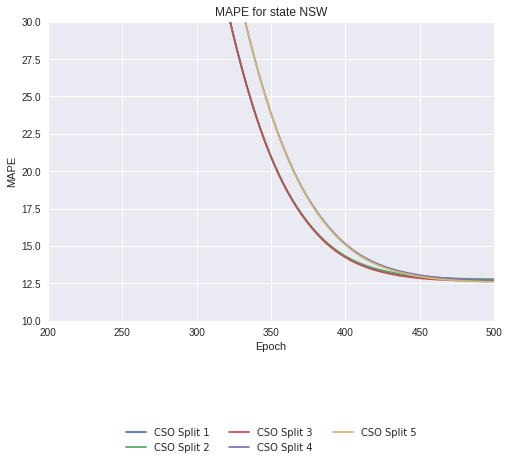

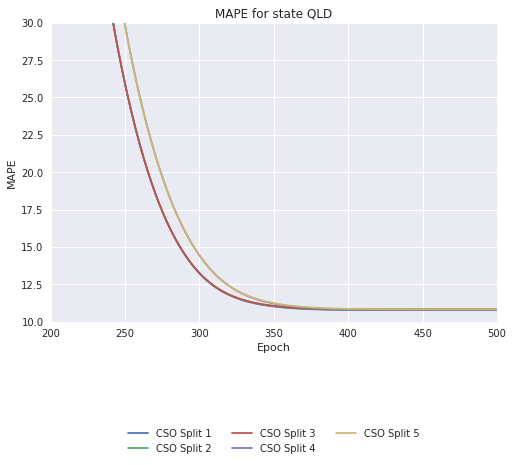

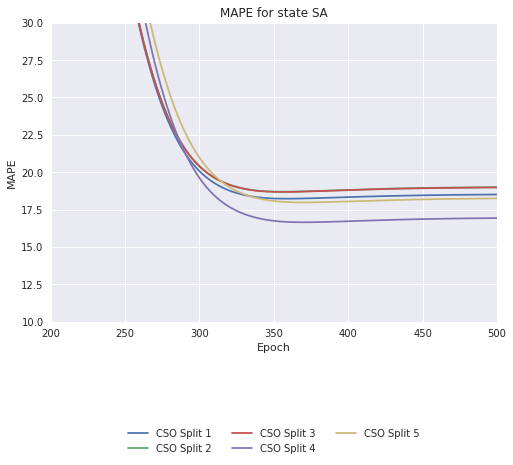

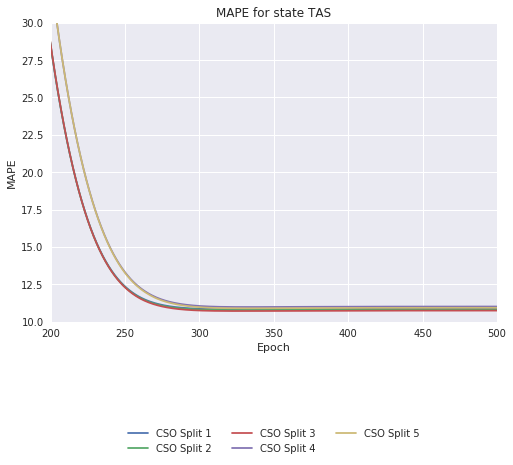

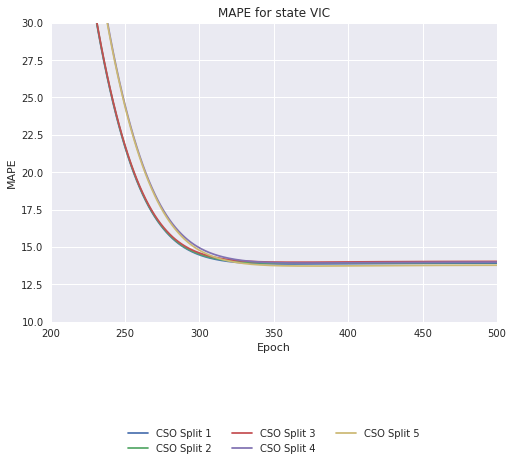

In [11]:
plot()